In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

In [3]:
train_new = False
model = 'CarHHMM2'

In [4]:
pars = Parameters.Parameters()

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

if model == 'CarHHM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

In [5]:
np.set_printoptions(suppress=True,precision=4)

In [6]:
s_dive = 0
e_dive = 266
pars.K[0] = 2
pars.K[1] = 3
pars.share_fine_states = True
HHMM_file = '../Params/%s_k_%s_%s_dives_same_fine_states_long' % (model,pars.K[0],pars.K[1])
print(HHMM_file)

../Params/CarHMM_k_2_3_dives_same_fine_states_long


# Preprocess Data

In [7]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

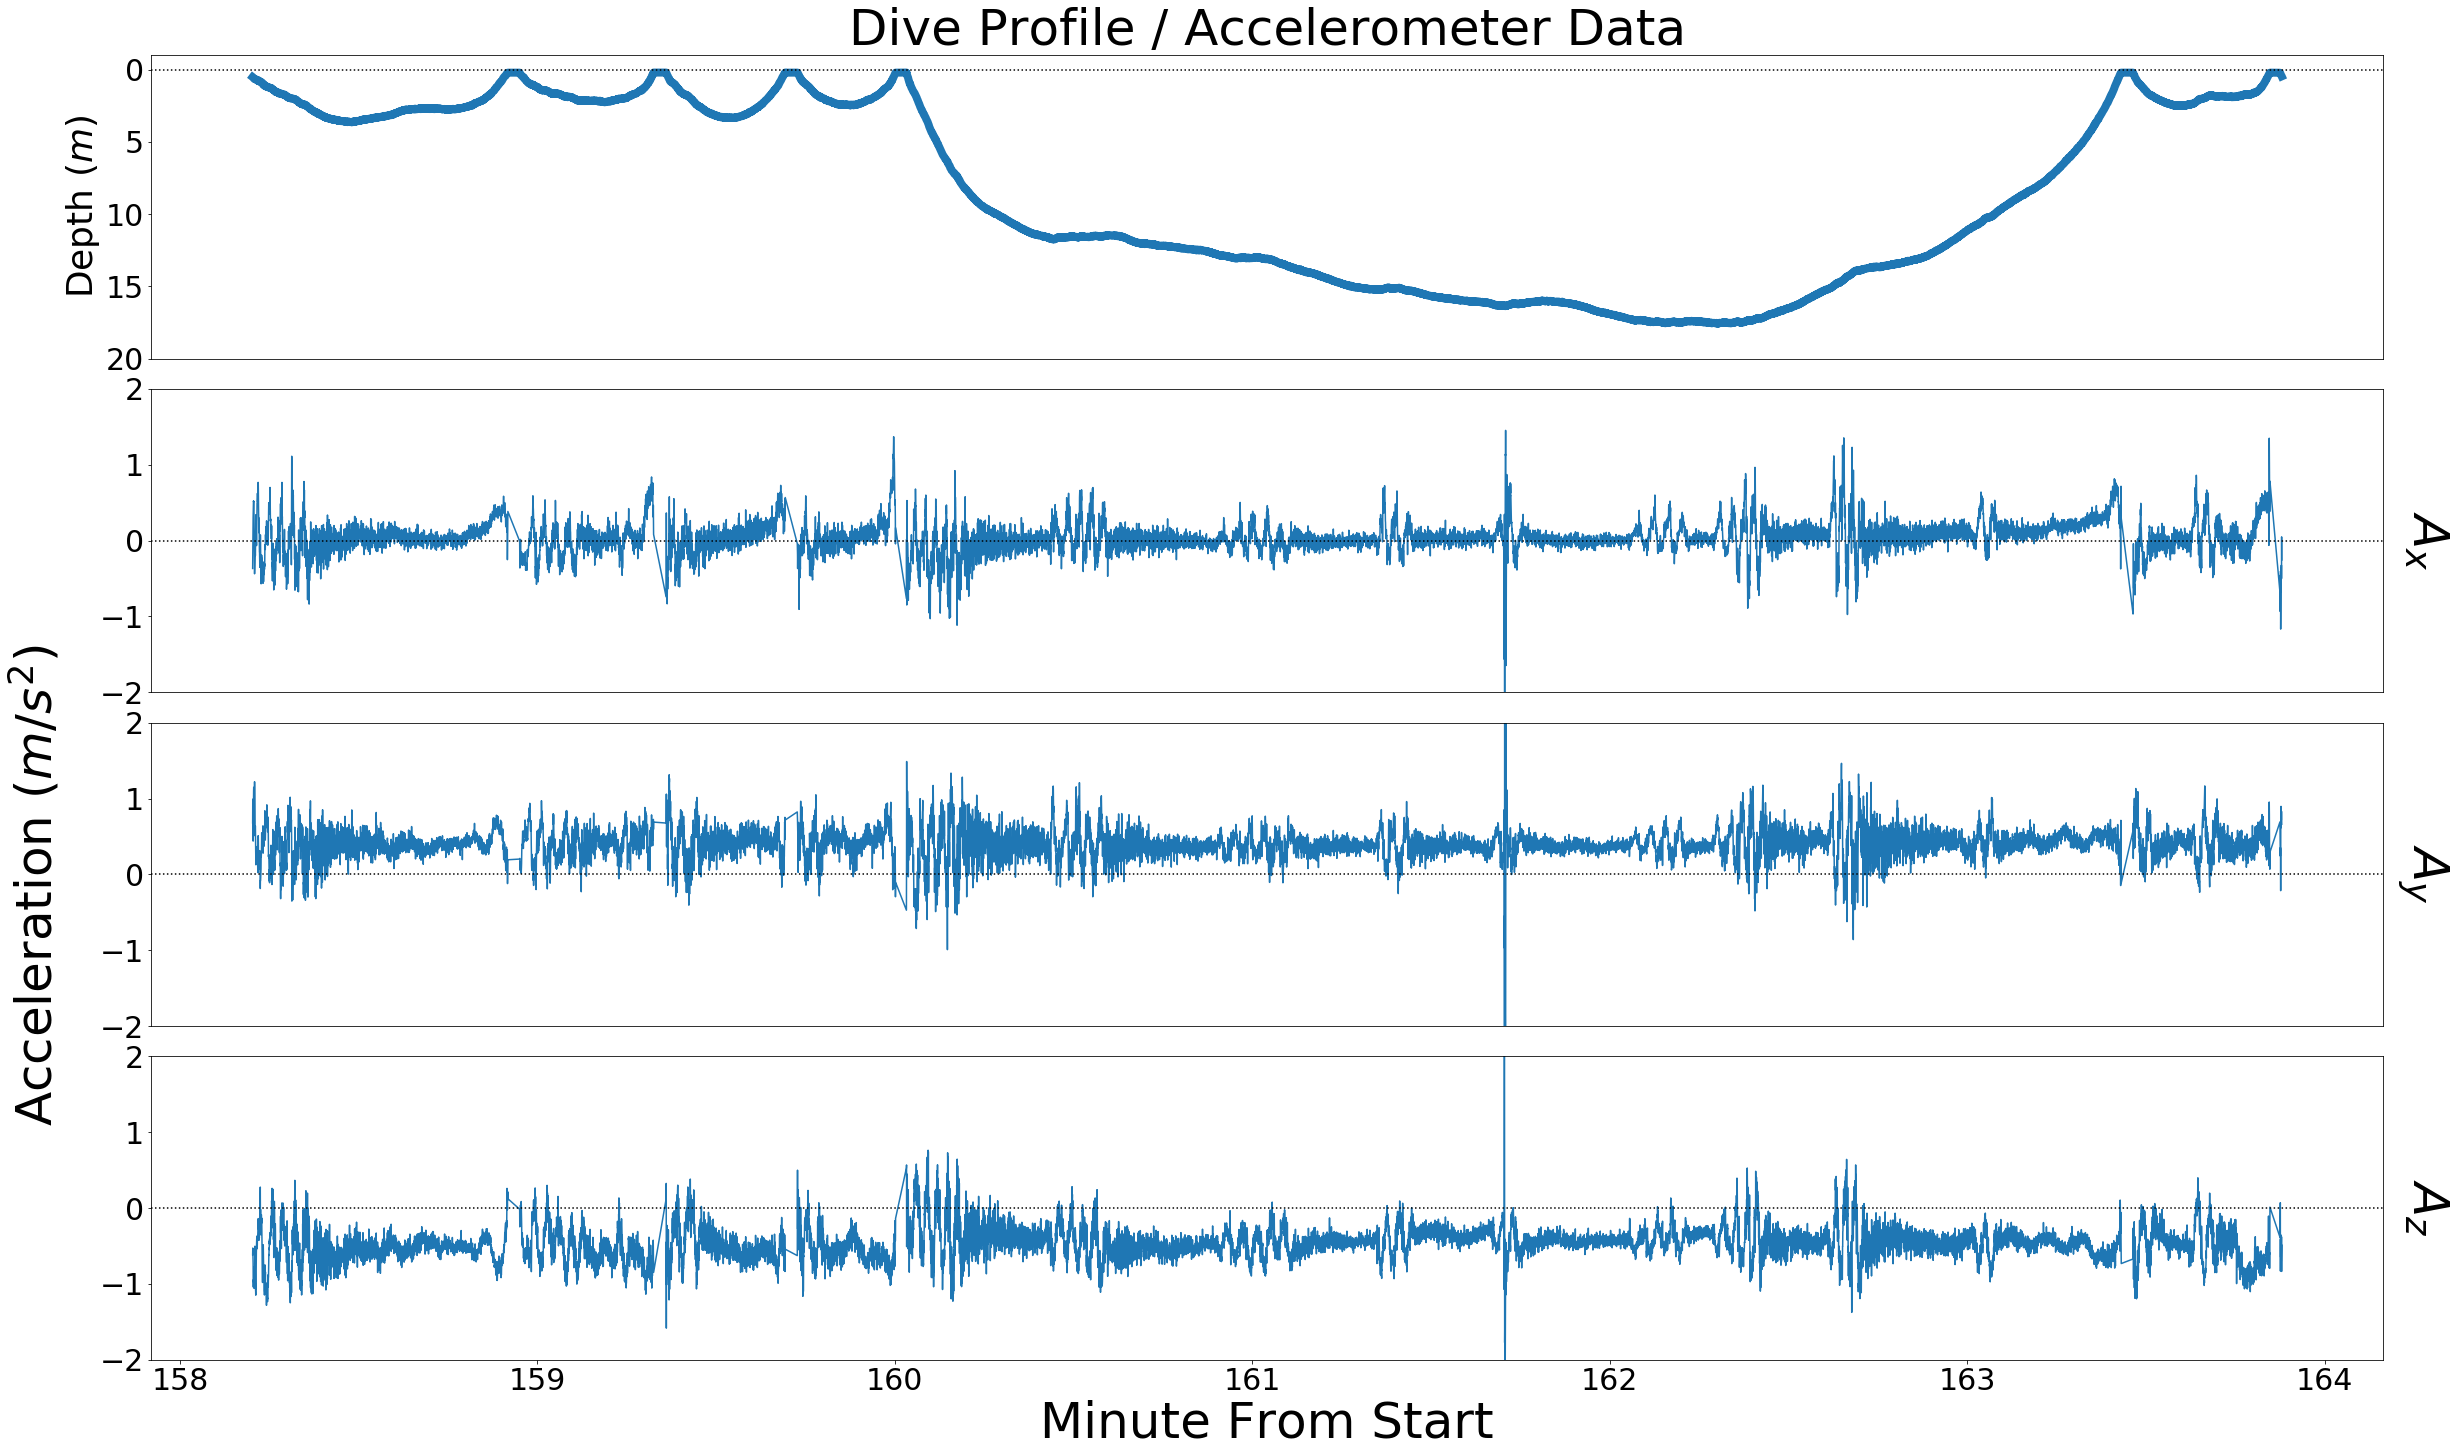

In [8]:
fig,ax = plt.subplots(4,1,figsize = (40,24))
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= 160) & (df['dive_num'] <= 165)]

plt.subplot(4,1,1)
plt.ylabel('Depth $(m)$',fontsize=30)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=8)
plt.title('Dive Profile / Accelerometer Data',fontsize=50)
plt.ylim([20,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('Depth $(m)$',fontsize=36)
plt.yticks(fontsize=30)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_x$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'])
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_y$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'])
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_z$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'])
plt.xlabel('Minute From Start',fontsize=50)
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

fig.text(0.075, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=50)
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.savefig('../Plots/raw_data_5_dives.png')
plt.show()

del temp_df

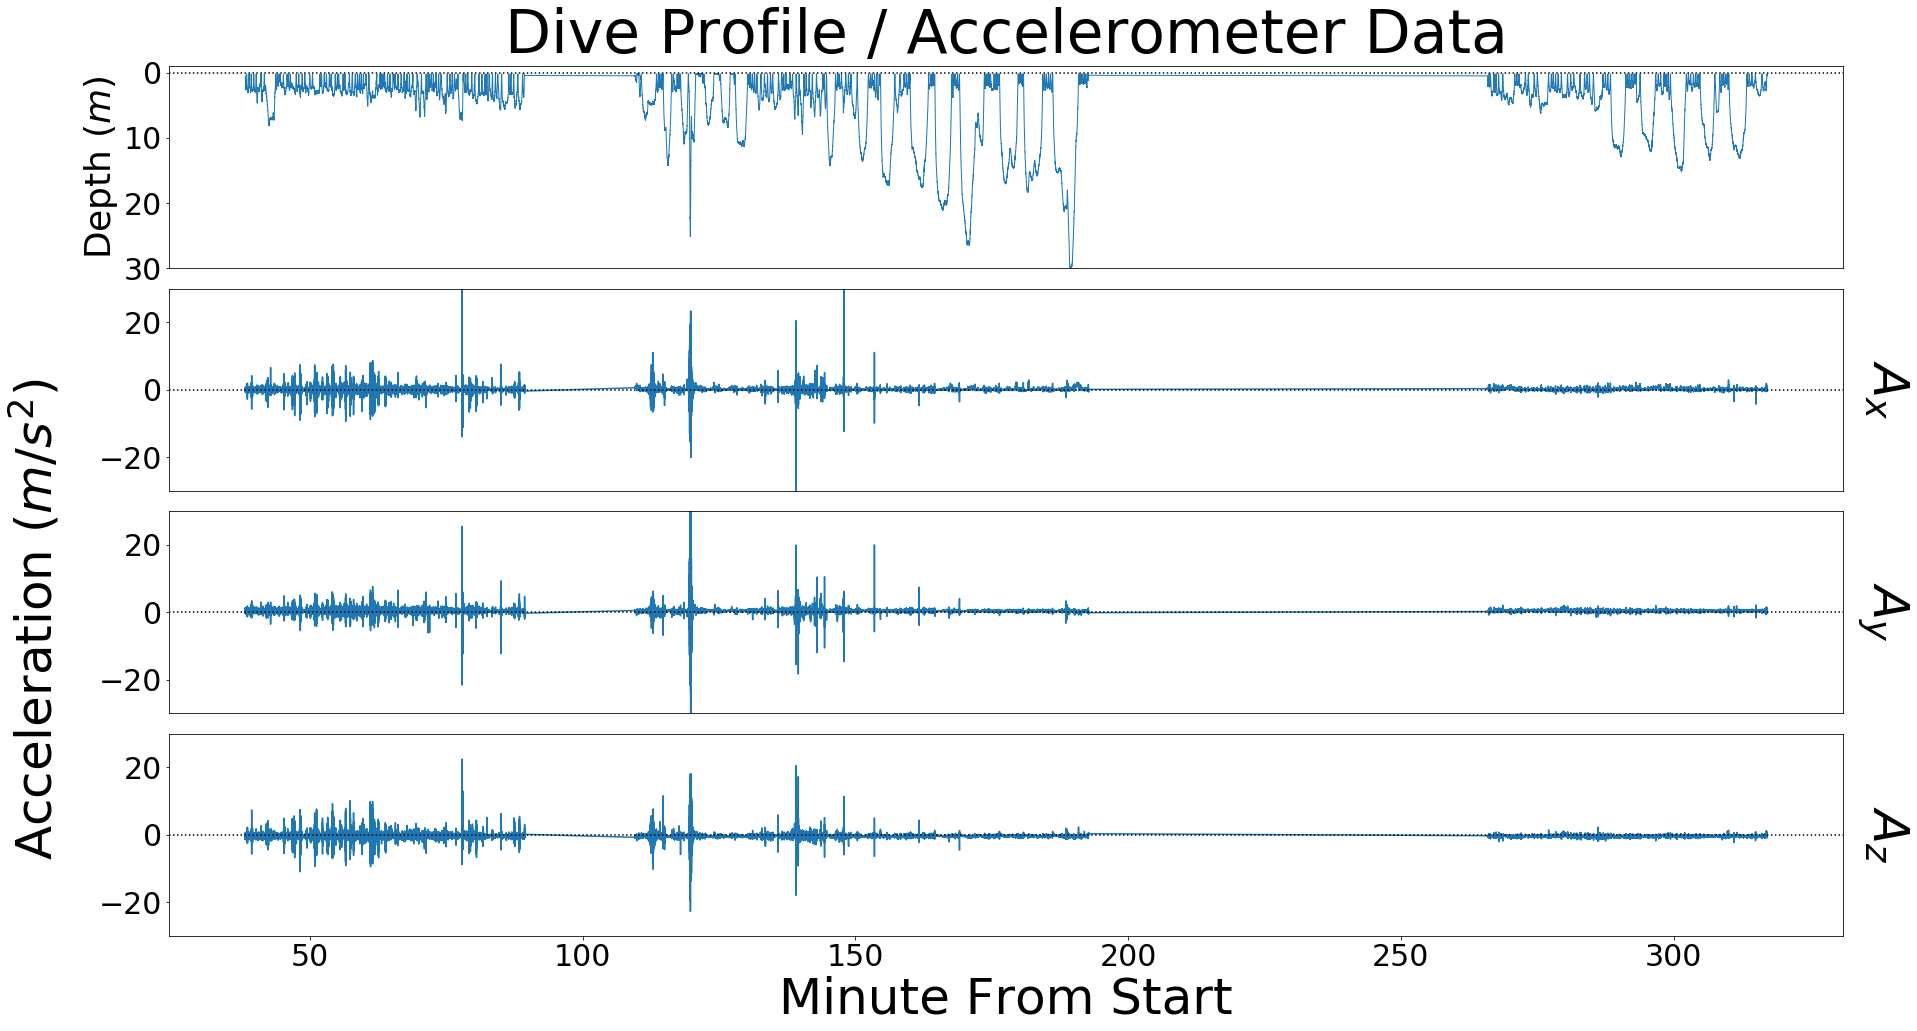

In [9]:
fig,ax = plt.subplots(4,1,figsize = (30,16),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=1)
plt.title('Dive Profile / Accelerometer Data',fontsize=60)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('Depth $(m)$',fontsize=36)
plt.yticks([0,10,20,30],fontsize=30)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.04,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_x$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'])
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,0,20],fontsize=30)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.04,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_y$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'])
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,0,20],fontsize=30)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.04,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_z$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'])
plt.xlabel('Minute From Start',fontsize=50)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,0,20],fontsize=30)
plt.xticks(fontsize=30)

fig.text(0.05, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=50)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/raw_data.png')
plt.show()

dive_duration
[[ 1.     -0.1272]
 [-0.1272  1.    ]]
Ax
[[1.     0.8574]
 [0.8574 1.    ]]
Ay
[[1.     0.6005]
 [0.6005 1.    ]]
Az
[[1.     0.7048]
 [0.7048 1.    ]]
Ahat_low
[[1.     0.8271]
 [0.8271 1.    ]]


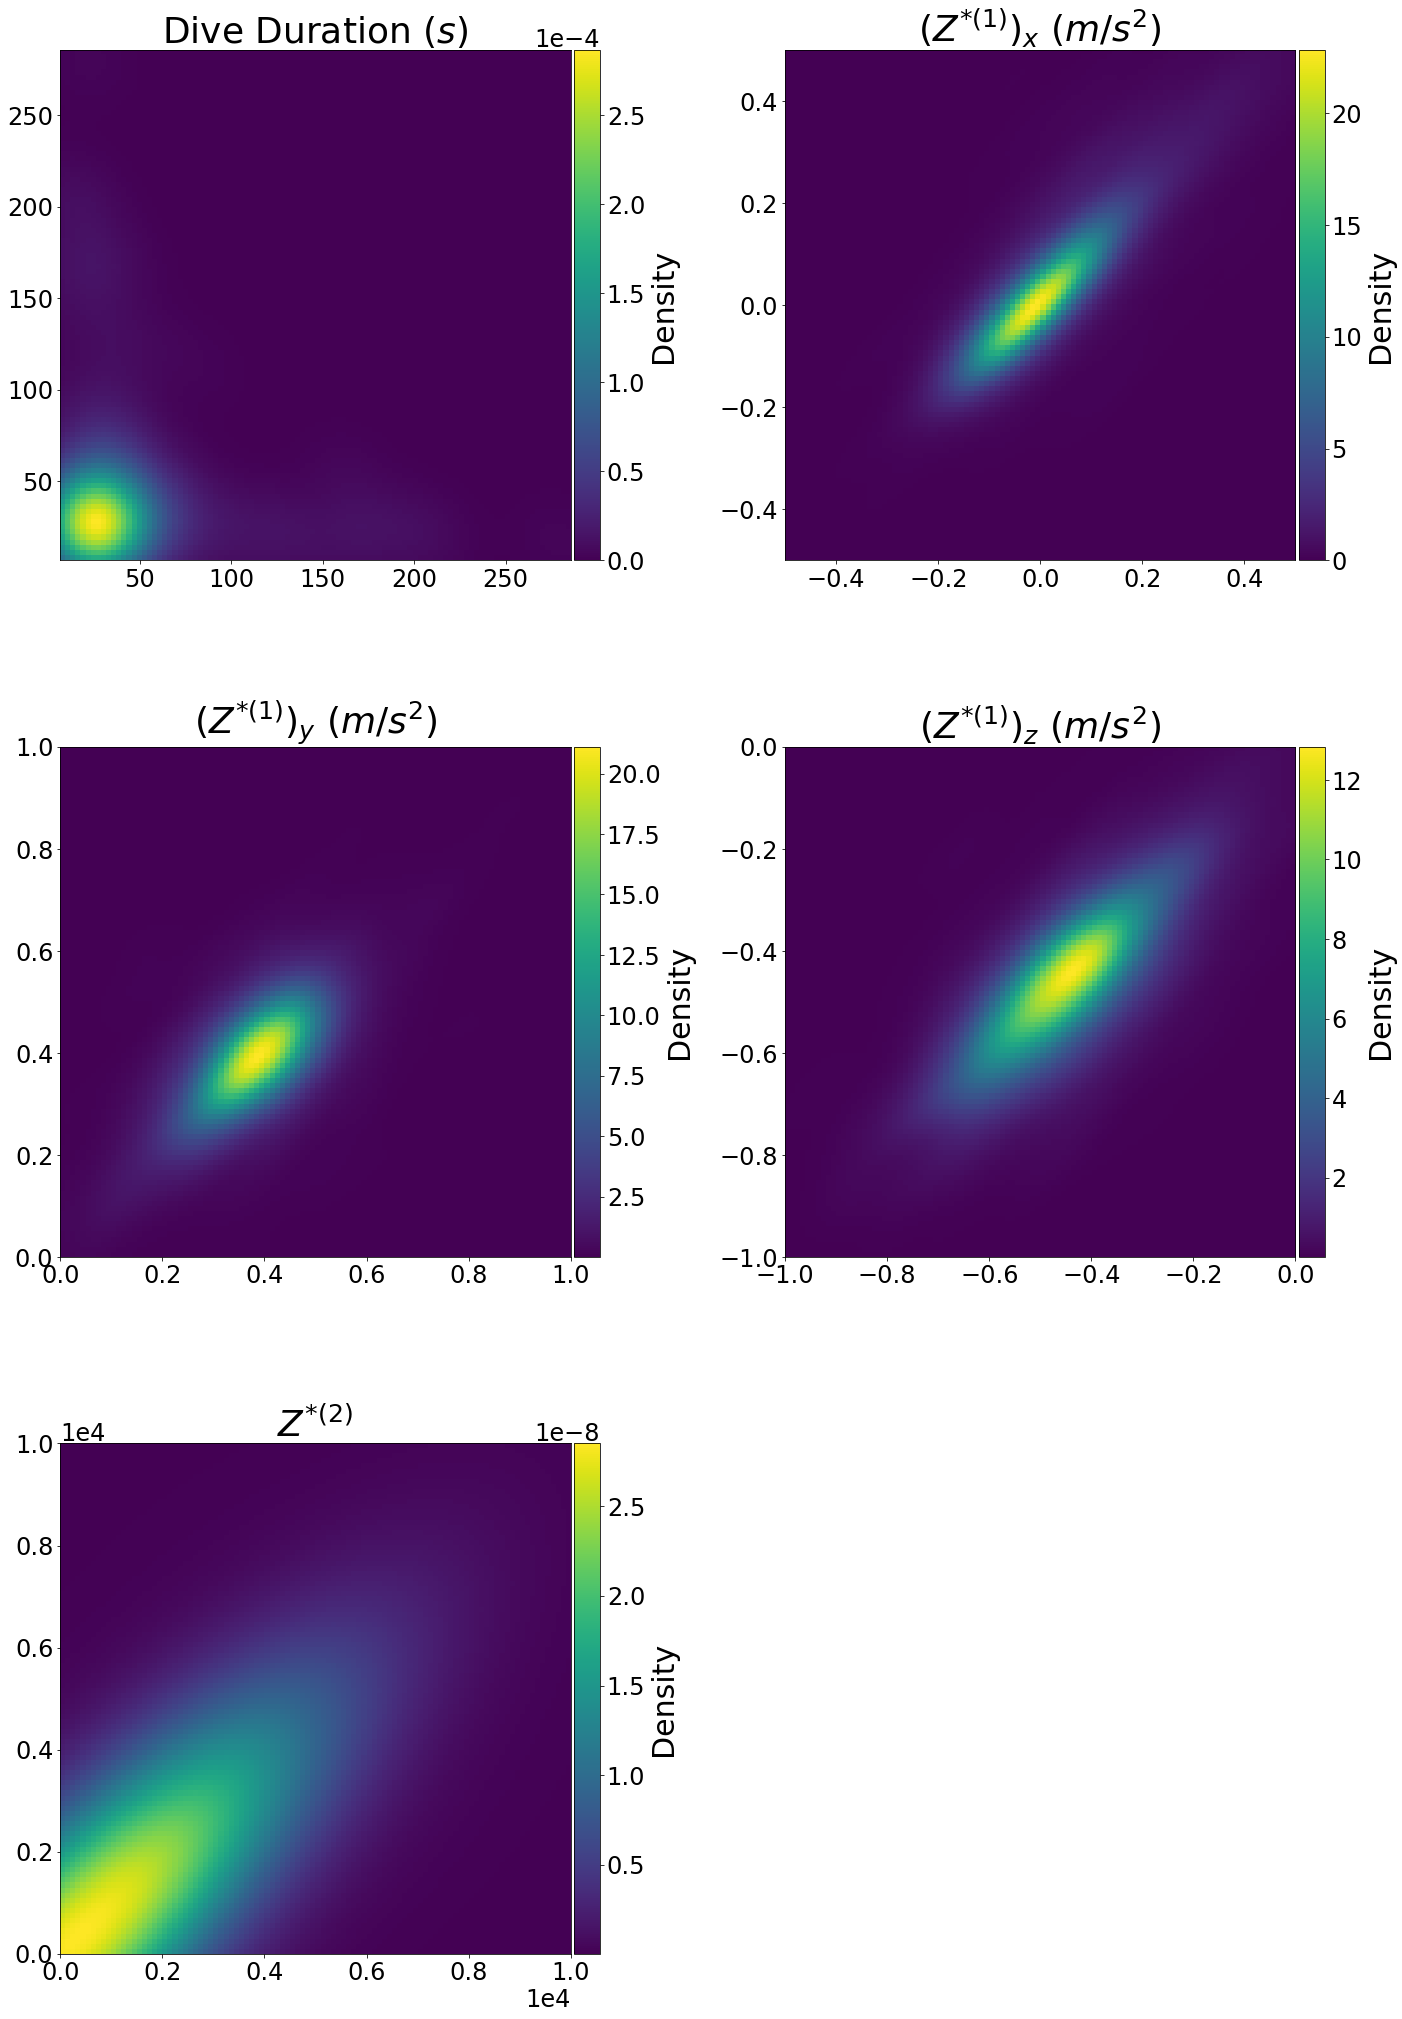

In [11]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/%s_lagplot.png'%model)

# Train HHMM

In [11]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)

# load model
hhmm = hhmm.load(HHMM_file)

stime = time.time()

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=5,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

    hhmm.save(HHMM_file)

print(hhmm.likelihood(deep_data))
print(time.time() - stime)
data,df = hhmm.label_df(data,df)

-20330.776159490193
4.246938228607178


# Visualize Results

-20330.776159490193
1 1
2 2
Probability transistion matrix for dive types:
[[0.7835 0.2165]
 [0.8067 0.1933]]

Stationary distribution for dive types:
[[0.7884 0.2116]]




Probability transistion matrix for subdive behaviors, dive type 1:
[[0.6919 0.3081 0.    ]
 [0.0412 0.9004 0.0584]
 [0.     0.2336 0.7664]]

Stationary Distribution for subdive behaviors, dive type 1:
[[0.0966 0.7227 0.1807]]


Probability transistion matrix for subdive behaviors, dive type 2:
[[0.8613 0.1387 0.    ]
 [0.113  0.8417 0.0453]
 [0.     0.2153 0.7847]]

Stationary Distribution for subdive behaviors, dive type 2:
[[0.4023 0.4938 0.1039]]


['dive_state_0_prob', 'dive_state_1_prob', 'subdive_state_0_prob', 'subdive_state_1_prob', 'subdive_state_2_prob']


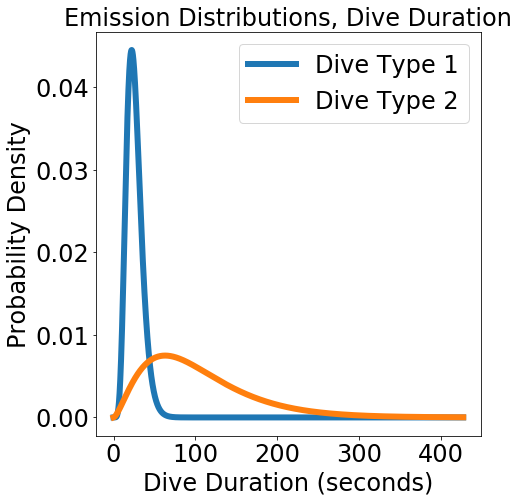

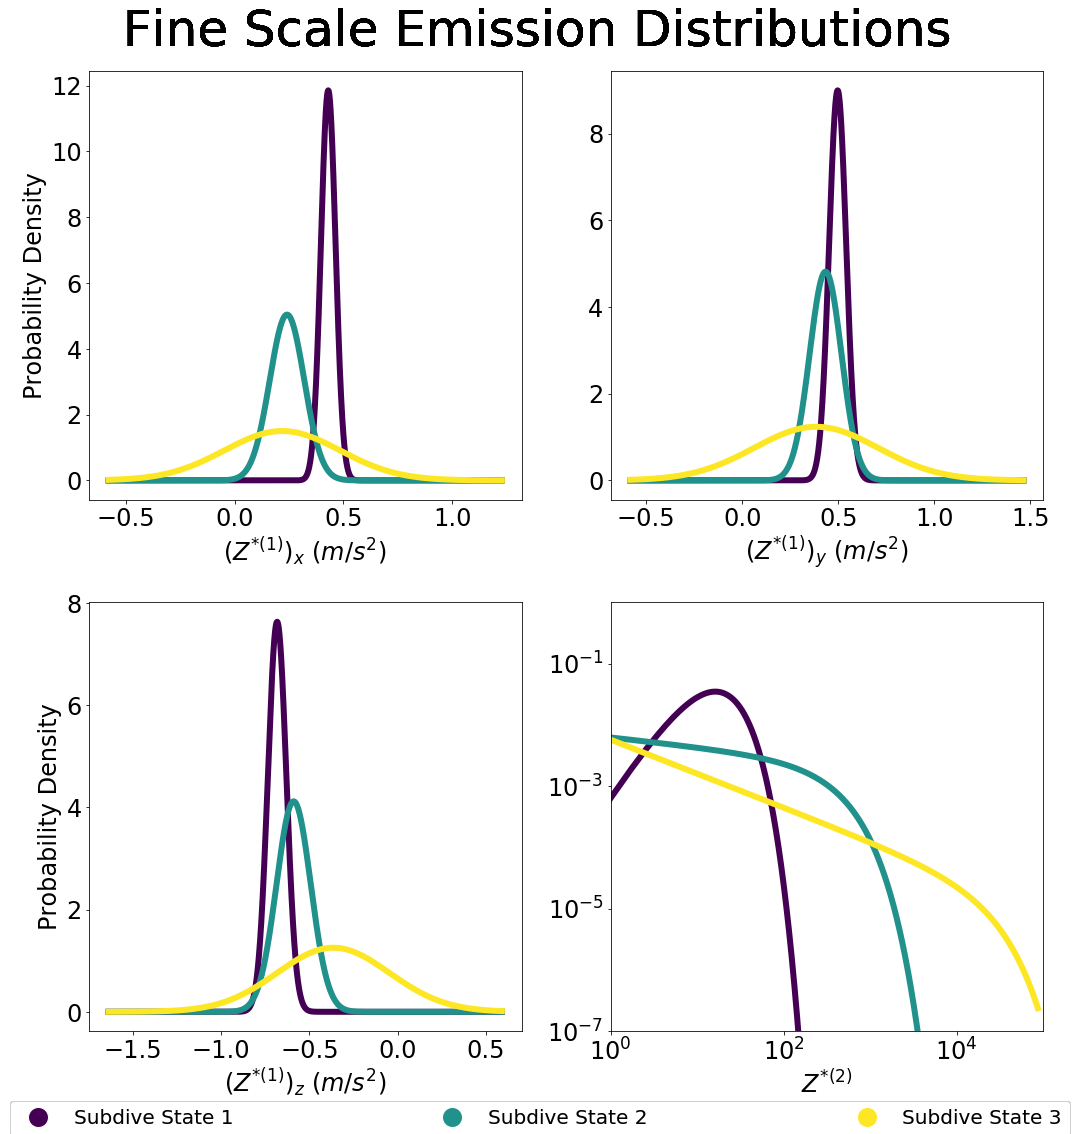

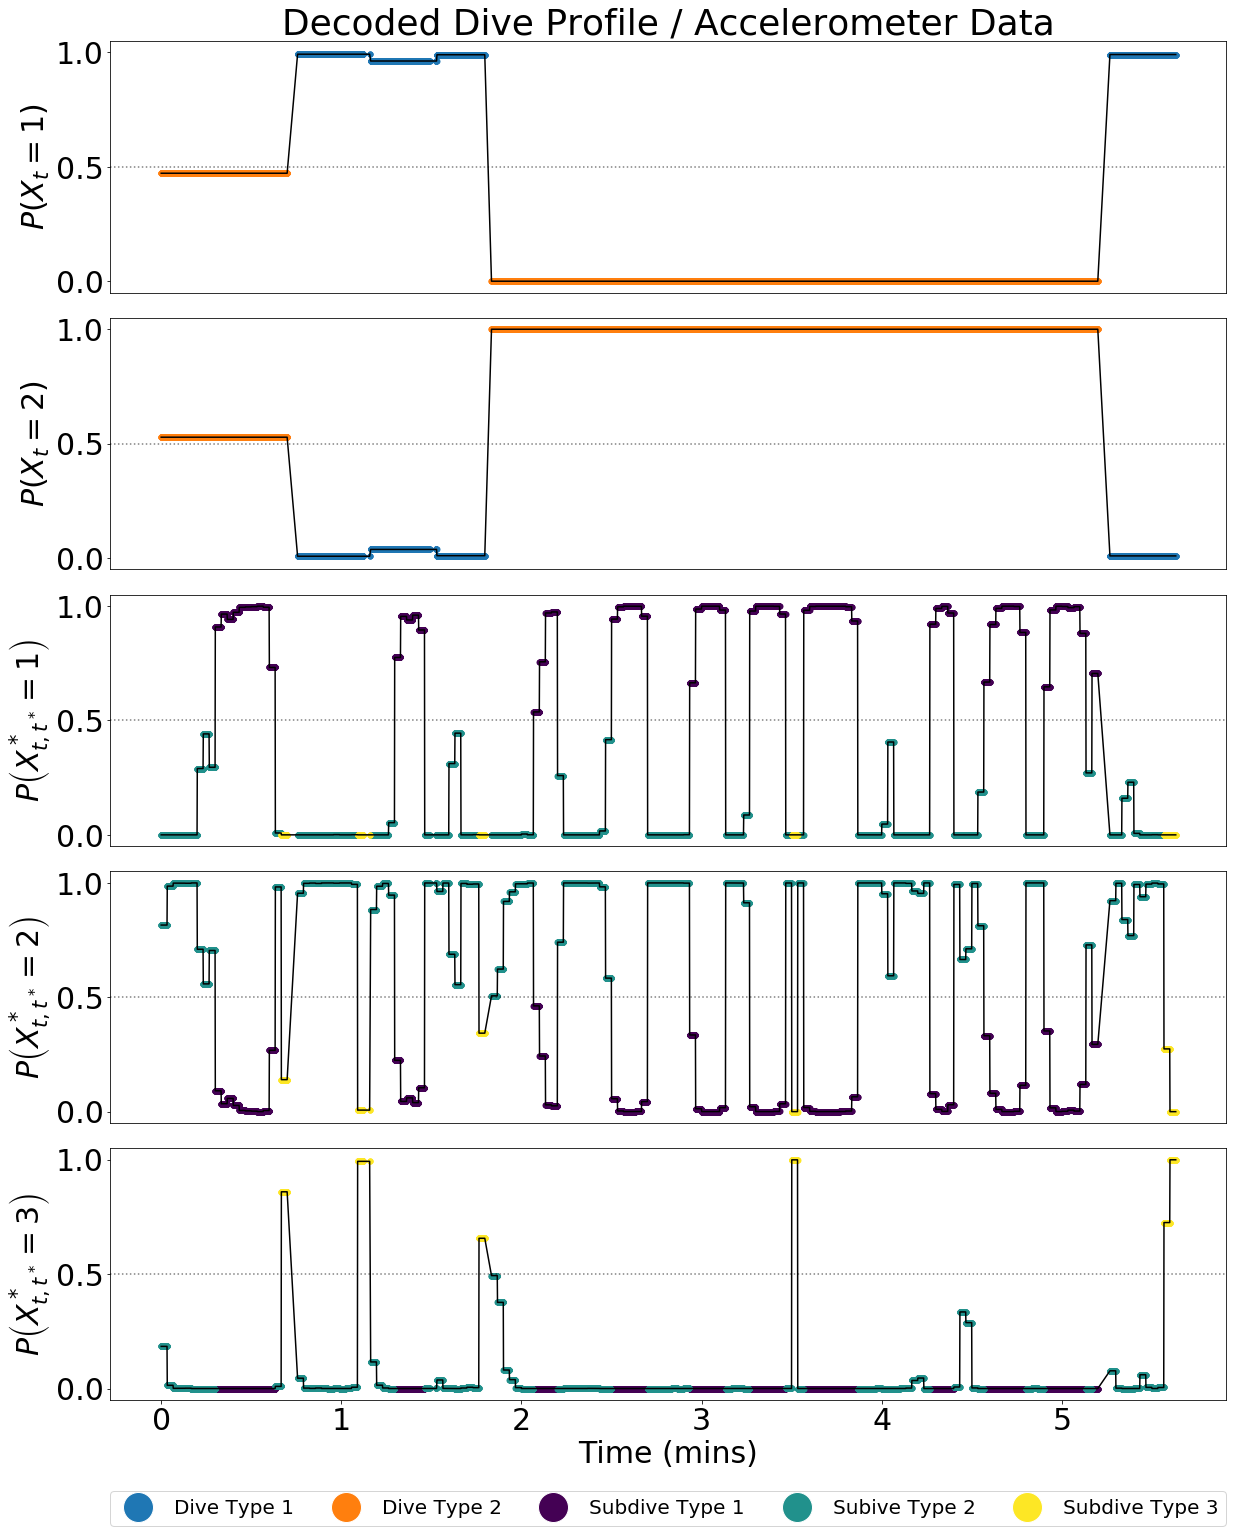

['Ax', 'depth']


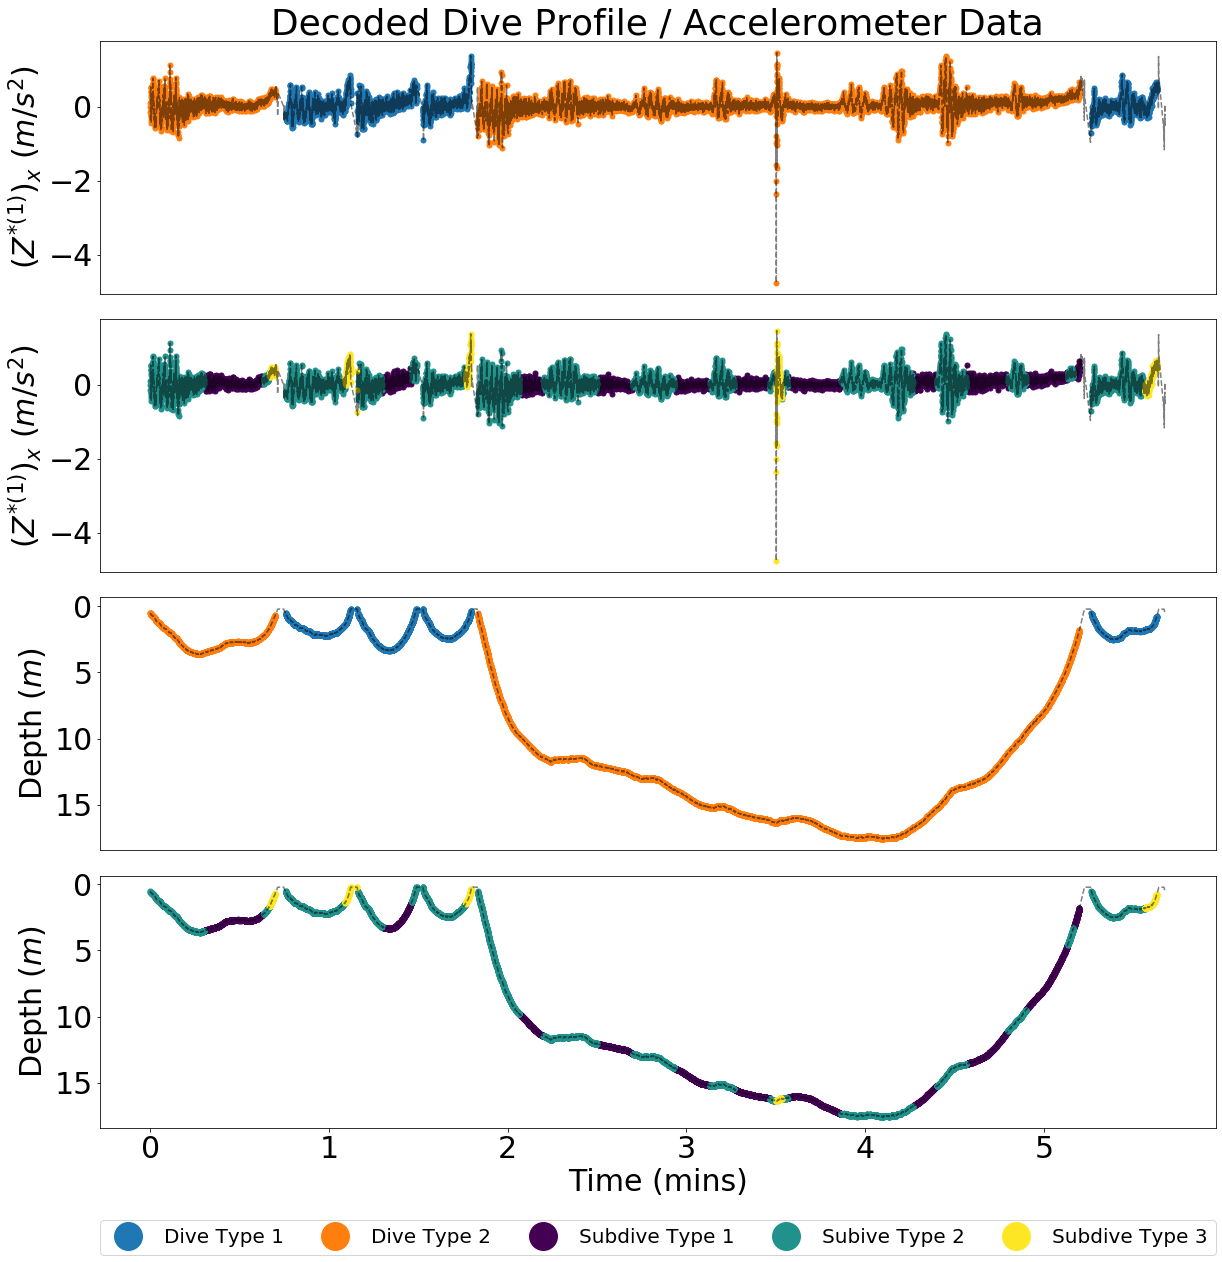

In [12]:
print(hhmm.likelihood(deep_data))

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/%s-coarse-emissions.png'%model)
if model == 'CarHHMM1':
    viz.plot_emission_probs(1,file='../Plots/%s-fine-emissions.png'%model,features=['Ax','Ay','Az'])
else:
    viz.plot_emission_probs(1,file='../Plots/%s-fine-emissions.png'%model)
viz.print_ptms()
viz.plot_dive_features(160,165,['dive_state_0_prob',
                                'dive_state_1_prob',
                                'subdive_state_0_prob',
                                'subdive_state_1_prob',
                                'subdive_state_2_prob'],[],
                       file = '../Plots/%s_decoded_states.png'%model,
                       nrows = 5)

plt.show()

viz.plot_dive_features(160,165,['Ax','depth'],[],
                       file = '../Plots/%s_decoded_dives.png'%model,
                       ylabs = [r'$\left(Z^{*(1)}\right)_x$ $(m/s^2)$',r'Depth $(m)$'],
                       nrows = 4)

# Histograms over emission distributions

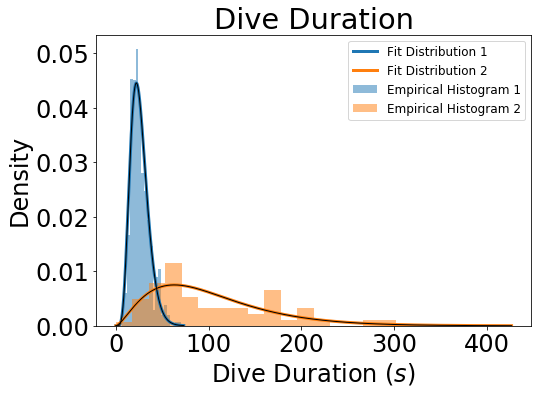

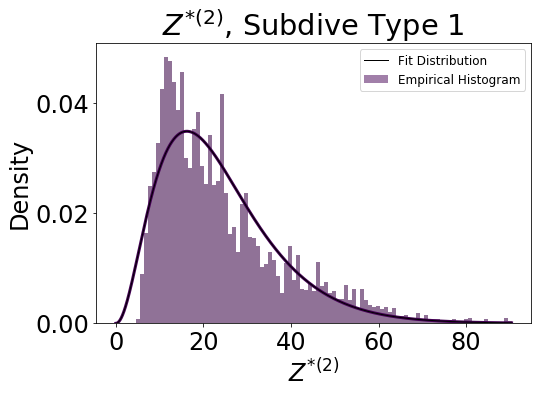

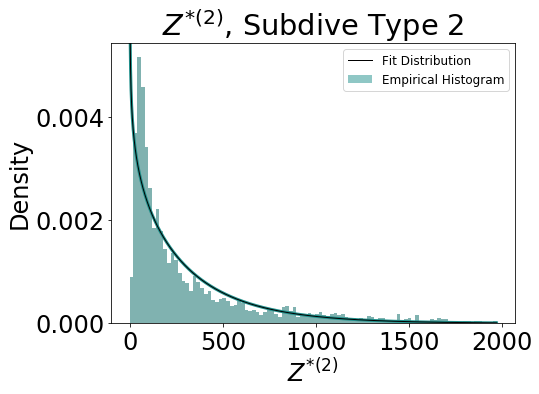

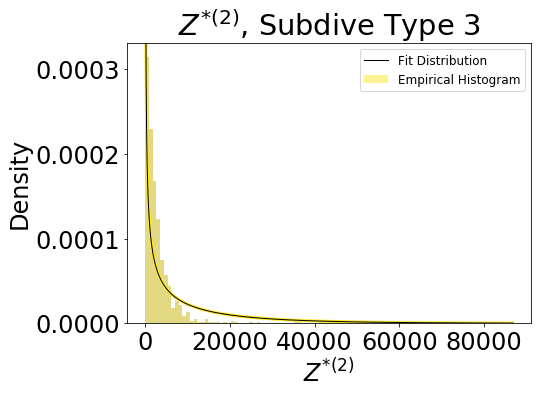

Ax


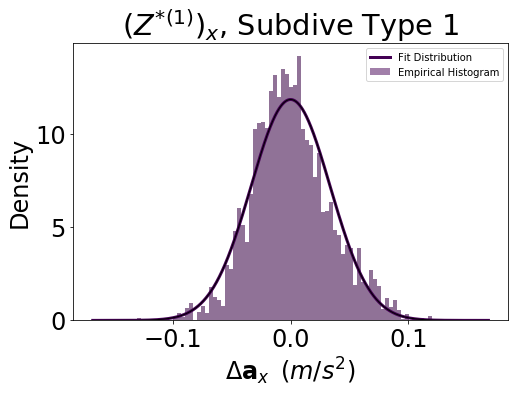

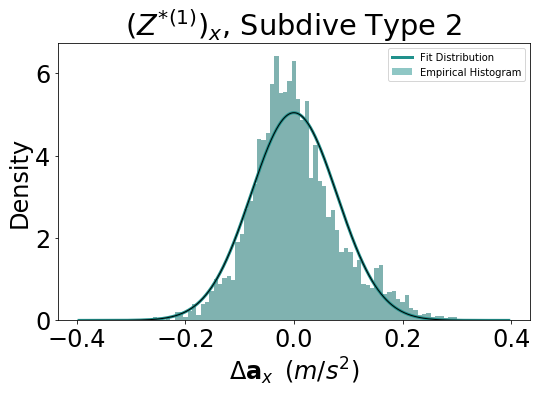

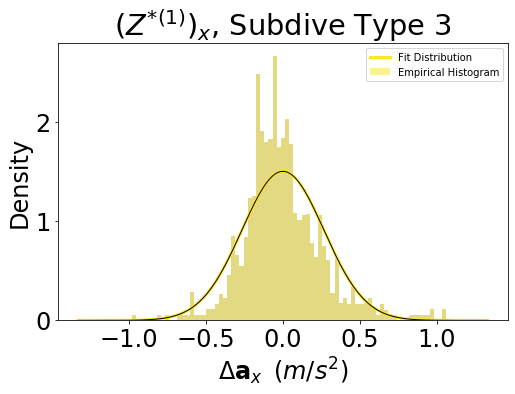

Ay


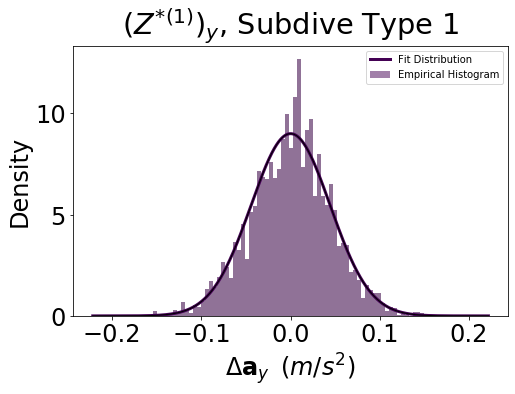

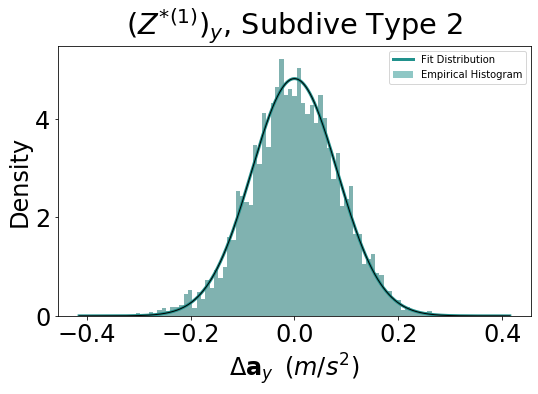

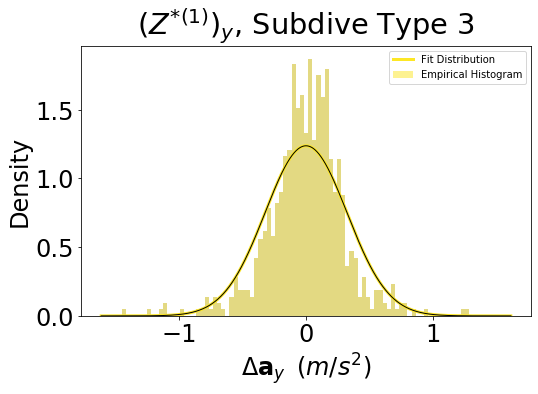

Az


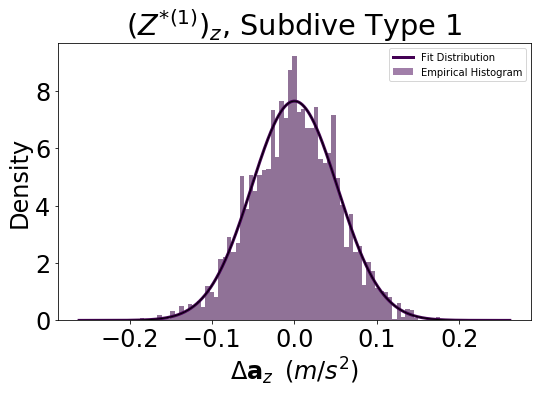

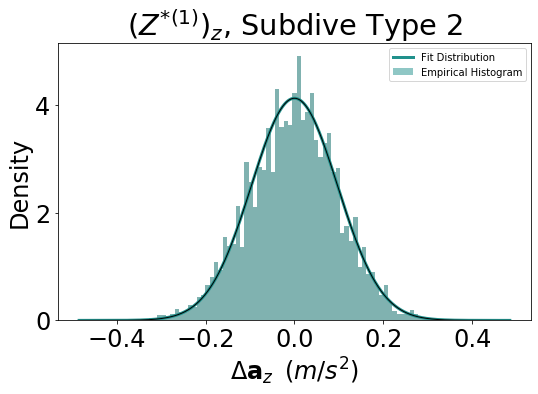

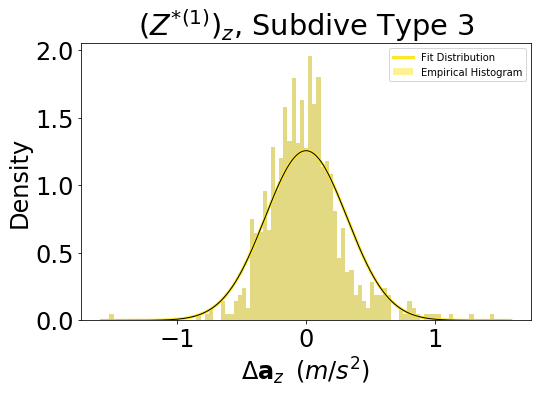

In [13]:
# colors
dive_colors = [cm.get_cmap('tab10')(0),
               cm.get_cmap('tab10')(1)]
subdive_colors = [cm.get_cmap('viridis')(0),
                  cm.get_cmap('viridis')(0.5),
                  cm.get_cmap('viridis')(1.0)]

# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

plt.figure(figsize=(8,6))
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=3)
    
plt.legend(['Fit Distribution 1','Fit Distribution 2','Empirical Histogram 1','Empirical Histogram 2'],fontsize=12)
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
plt.title('Dive Duration')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/%s_empirical_hist_dive_duration.png'%model)
plt.show()
    
# A-hat
if model != 'CarHHMM1':
    weights = [list([]),list([]),list([])]
    values = []

    for dive in data:
        for seg in dive['subdive_features']:
            weights[0].append(seg['subdive_state_probs'][0])
            weights[1].append(seg['subdive_state_probs'][1])
            weights[2].append(seg['subdive_state_probs'][2])
            values.append(seg['Ahat_low'])

    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(8,6))
        bins = np.linspace(0.01,mu[state]+5*sig[state],100)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        x = np.linspace(0.01,mu[state]+5*sig[state],10000)
        y = gamma.pdf(x,shape[state],0,scale[state])
        plt.plot(x,y,color='k',linewidth=1)
        plt.title(r'$Z^{*(2)}$, Subdive Type %d'%(state+1))
        plt.xlim(xlim)
        plt.xlabel(r'$Z^{*(2)}$')
        plt.ylim(ylim)
        plt.ylabel('Density')
        plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
        plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
        plt.plot(x,y,color=subdive_colors[state],linewidth=3)
        plt.plot(x,y,color='k',linewidth=1)
        plt.tight_layout()
        plt.savefig('../Plots/%s_empirical_hist_ahat_%d.png'%(model,state))
        plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        plt.figure(figsize=(8,6))
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=3)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(Z^{*(1)}\right)_%s$, Subdive Type %d'%(feature[-1],state+1))
        plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=10)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/%s_empirical_hist_%s_%d.png'%(model,feature,state))
        plt.show()

# Psuedoresiduals

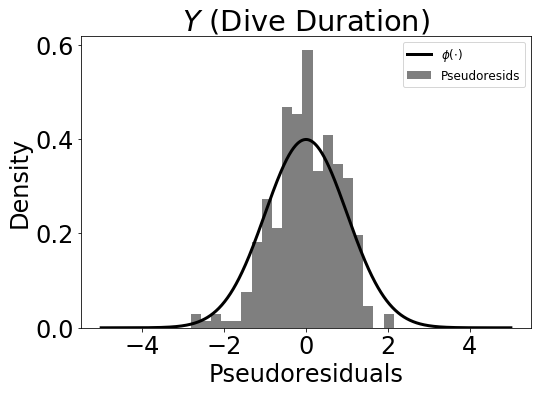

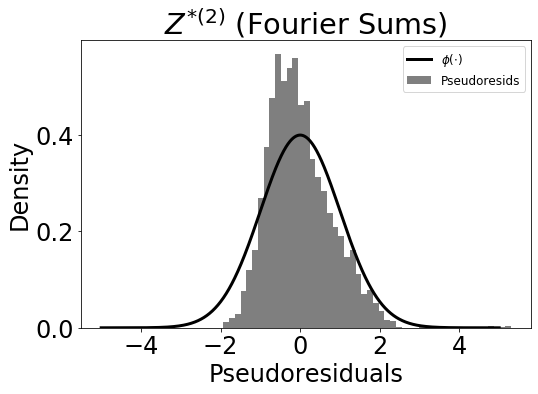

Ax


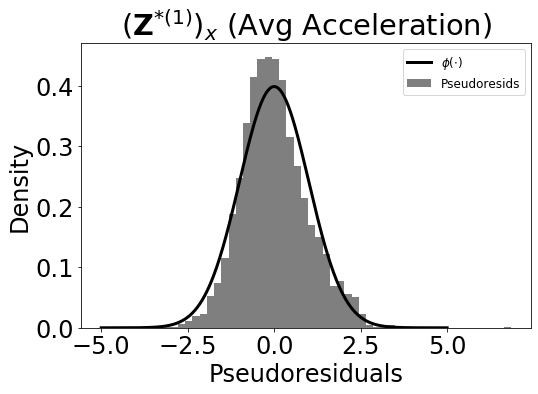

Ay


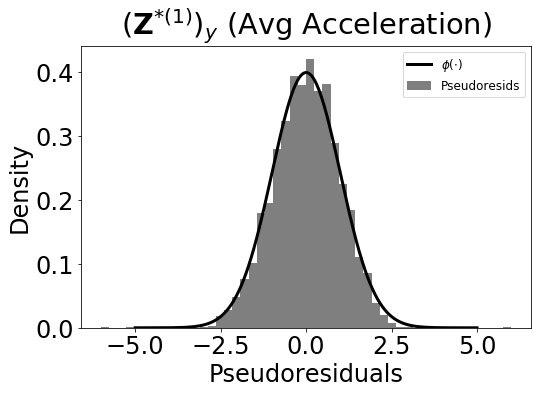

Az


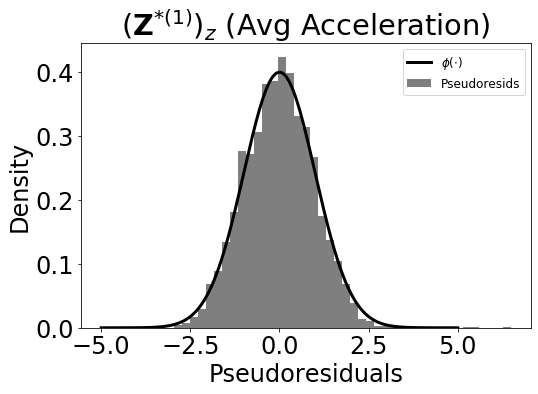

In [14]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(8,6))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title('$Y$ (Dive Duration)')
plt.plot(x,y,color='k',linewidth=3)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/%s_psedoresids_Dive_Duration.png'%model)
plt.show()

# A-hat
if model != 'CarHHMM1':
    mu = hhmm.theta[1][0]['Ahat_low']['mu']
    sig = hhmm.theta[1][0]['Ahat_low']['sig']
    shape = np.square(mu)/np.square(sig)
    scale = np.square(sig)/np.array(mu)

    psuedoresids = []

    for dive in data:
        for seg in dive['subdive_features']:
            cdf = 0
            for state in range(hhmm.pars.K[1]):
                cdf += seg['subdive_state_probs'][state] * \
                        gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
            psuedoresids.append(norm.ppf(cdf))

    plt.figure(figsize=(8,6))     
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.title(r'$Z^{*(2)}$ (Fourier Sums)')
    plt.plot(x,y,color='k',linewidth=3)
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s_psedoresids_ahat.png'%model)
    plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(8,6))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=3)
    plt.title(r'$\left(\mathbf{Z}^{*(1)}\right)_%s$ (Avg Acceleration)'%feature[-1])
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/%s_psedoresids_%s.png'%(model,feature))
    plt.show()   

# Make Tables

In [15]:
if model == 'CarHHMM2':
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_x$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_y$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_z$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{Fourier sum - $Z^{*(2)}$}                                      & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    
elif model == 'CarHHMM1':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_x$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_y$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_z$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2])

    print(table)
    
elif model == 'HHMM':
    
    table = r'''
    \begin{table}[h!]
    \centering
    \label{table:emis_dists}
    \caption{Estimates and standard errors of parameters for killer whale data.}
    \begin{tabular}{ccccc}
    \multirow{2}{*}{Feature}                                                       & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                                                                   &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
    \multirow{2}{*}{Dive Duration $(s)$ - $Y$}                                     & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{x-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_x$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{y-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_y$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{z-acceleration $(m/s^2)$ - $\left(\mathbf{Z}^{*(1)}\right)_z$} & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \multirow{3}{*}{Fourier sum - $Z^{*(2)}$}                                      & 1                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 2                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\
                                                                                   & 3                                    & $%.3f \pm %.3f$ & $%.3f \pm %.3f$ & ---             \\ \hline
    \end{tabular}
    \end{table}
    ''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
           hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
           hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
           hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
           hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
           hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
           hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
           hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
           hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
           hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
           hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
           hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
           hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
           hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
           hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
           hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
           hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
           hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
           hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
           hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
           hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
           hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
           hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
           hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
           hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
           hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
           hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

    print(table)
    

In [16]:
ptm = HHMM.eta_2_ptm(hhmm.eta[0])
delta = np.array([0.5,0.5])
for _ in range(100):
    delta = delta.dot(ptm)

gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
%.3f & %.3f \\
%.3f & %.3f
\end{pmatrix}$$
$$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
'''% tuple(np.concatenate([ptm.flatten(),delta]))

print(gamma0)

$$\hat \Gamma = \begin{pmatrix} 
0.784 & 0.216 \\
0.807 & 0.193
\end{pmatrix}$$
$$\hat \delta = \begin{pmatrix} 0.788 & 0.212 \end{pmatrix}$$



In [17]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
delta2 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta2 = delta2.dot(ptm2)

gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f
\end{pmatrix}$$
$$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

$$\hat \Gamma^{*(2)} = \begin{pmatrix} 
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f
\end{pmatrix}$$
$$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))

print(gamma0)

$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
0.692 & 0.308 & 0.000 \\
0.041 & 0.900 & 0.058 \\
0.000 & 0.234 & 0.766
\end{pmatrix}$$
$$\hat \delta^{*(1)} = \begin{pmatrix} 0.097 & 0.723 & 0.181 \end{pmatrix}$$

$$\hat \Gamma^{*(2)} = \begin{pmatrix} 
0.861 & 0.139 & 0.000 \\
0.113 & 0.842 & 0.045 \\
0.000 & 0.215 & 0.785
\end{pmatrix}$$
$$\hat \delta^{*(2)} = \begin{pmatrix} 0.402 & 0.494 & 0.104 \end{pmatrix}$$



# Check Autocorrelation within states

In [18]:
Ax_t = [[] for _ in range(3)]
Ax_tp1 = [[] for _ in range(3)]
Ay_t = [[] for _ in range(3)]
Ay_tp1 = [[] for _ in range(3)]
Az_t = [[] for _ in range(3)]
Az_tp1 = [[] for _ in range(3)]

for dive in data:
    seg_type_t = -1
    ax_tm1 = 0
    ay_tm1 = 0
    az_tm1 = 0
    for seg in dive['subdive_features']:
        seg_type_tp1 = np.argmax(seg['subdive_state_probs'])
        if seg_type_tp1 == seg_type_t:
            
            Ax_t[seg_type_t].append(ax_tm1)
            Ay_t[seg_type_t].append(ay_tm1)
            Az_t[seg_type_t].append(az_tm1)
            
            Ax_tp1[seg_type_t].append(seg['Ax'])
            Ay_tp1[seg_type_t].append(seg['Ay'])
            Az_tp1[seg_type_t].append(seg['Az'])
        
        ax_tm1 = seg['Ax']
        ay_tm1 = seg['Ay']
        az_tm1 = seg['Az']
        
        seg_type_t = seg_type_tp1

i = 0
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))
print('')
i += 1
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))
print('')
i += 1
print(np.corrcoef(Ax_t[i],Ax_tp1[i]))
print(np.corrcoef(Ay_t[i],Ay_tp1[i]))
print(np.corrcoef(Az_t[i],Az_tp1[i]))

[[1.     0.9811]
 [0.9811 1.    ]]
[[1.     0.8998]
 [0.8998 1.    ]]
[[1.     0.9088]
 [0.9088 1.    ]]

[[1.     0.9236]
 [0.9236 1.    ]]
[[1.   0.69]
 [0.69 1.  ]]
[[1.     0.7587]
 [0.7587 1.    ]]

[[1.     0.6791]
 [0.6791 1.    ]]
[[1.     0.5115]
 [0.5115 1.    ]]
[[1.     0.5785]
 [0.5785 1.    ]]


In [19]:
#h = 0.01

#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += h
#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += -2*h
#print(hhmm.likelihood(data))
#hhmm.eta[1][0][0,1] += h
#print(hhmm.likelihood(data))

In [20]:
#h = 0.95
#print(hhmm.likelihood(data))
#hhmm.theta[1][0]['Ax']['corr'][2] = h
#hhmm.theta[1][1]['Ax']['corr'][2] = h
#hhmm.theta[1][0]['Ay']['corr'][2] = h
#hhmm.theta[1][1]['Ay']['corr'][2] = h
#hhmm.theta[1][0]['Az']['corr'][2] = h
#hhmm.theta[1][1]['Az']['corr'][2] = h
#print(hhmm.likelihood(data))

In [21]:
#hhmm.theta[1][0]['Ax']['corr'][2]

In [22]:
#hhmm.save(HHMM_file)

In [23]:
np.argmax(data[1]['subdive_features'][0]['subdive_state_probs'])

2